In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Masking
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from collections import Counter
from math import log
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import MaxNLocator
drive.mount('/content/drive')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/MASTER-BDMA-ULB/Data Mining/time_sorted_table.csv', delimiter=';', index_col=0)

cols_to_transform = ['vehicles_sequence', 'events_sequence', 'seconds_to_incident_sequence',
                     'train_kph_sequence', 'dj_ac_state_sequence', 'dj_dc_state_sequence']

for col in cols_to_transform:
    df[col] = df[col].apply(literal_eval)

print(df.shape)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1011, 10)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1011 entries, 0 to 1010
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   incident_id                   1011 non-null   int64  
 1   vehicles_sequence             1011 non-null   object 
 2   events_sequence               1011 non-null   object 
 3   seconds_to_incident_sequence  1011 non-null   object 
 4   approx_lat                    1011 non-null   float64
 5   approx_lon                    1011 non-null   float64
 6   train_kph_sequence            1011 non-null   object 
 7   dj_ac_state_sequence          1011 non-null   object 
 8   dj_dc_state_sequence          1011 non-null   object 
 9   incident_type                 1011 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 86.9+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Preparation

In [ ]:
total_rows = len(df)
incident_counts = df['incident_type'].value_counts()


print(incident_counts)


incident_type
13    318
99    175
14    149
2     119
9     117
4      78
11     26
17     10
6       6
3       5
16      4
7       4
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
min_occurrences = 50
filtered_incident_types = incident_counts[incident_counts >= min_occurrences].index
filtered_df = df[df['incident_type'].isin(filtered_incident_types)]
print(filtered_df['incident_type'].value_counts())

incident_type
13    318
99    175
14    149
2     119
9     117
4      78
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


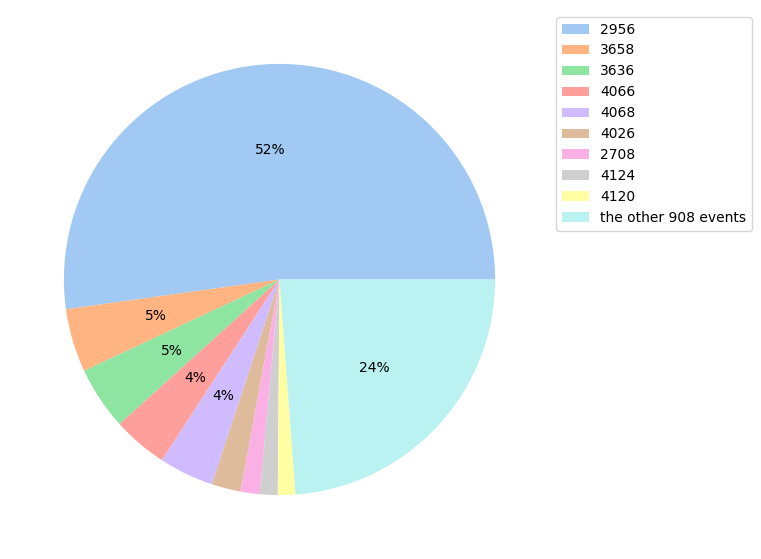

,event,counts_on_total
78,2956,291975
80,3658,26608
79,3636,26491
26,4066,23018
23,4068,22951
...,...,...
835,4372,1
837,2446,1
839,1040,1
811,3444,1


In [ ]:
all_events = np.concatenate(df.events_sequence)

event_counts = pd.DataFrame.from_dict(Counter(all_events), orient='index', columns=['counts_on_total'])
event_counts = event_counts.reset_index(names='event').sort_values(by='counts_on_total', ascending=False)

first_x = 9

counts_first_x = event_counts[:first_x].copy()
counts_others = pd.DataFrame(data = {
    'event': [f'the other {event_counts.shape[0] - first_x} events'],
    'counts_on_total': [event_counts.counts_on_total[first_x:].sum()]
})

def autopct_more_than_3(pct):
    return ('%1.f%%' % pct) if pct > 3 else ''

event_counts_summarized = pd.concat([counts_first_x, counts_others])
colors = sns.color_palette('pastel')
fig, ax = plt.subplots(figsize=(7, 7))
plt.pie(event_counts_summarized.counts_on_total, autopct=autopct_more_than_3, colors=colors)
ax.legend(event_counts_summarized.event, loc='best', bbox_to_anchor=(1,1))
plt.show()

display(event_counts)

In [ ]:
high_frequency_event = 2956

filtered_df['events_sequence'] = filtered_df.events_sequence.apply(
    lambda sequence: [event for event in sequence if event != high_frequency_event]
)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-60-8457fd9ef786>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['events_sequence'] = filtered_df.events_sequence.apply(


In [ ]:
def drop_records_stopped_before_epsilon(dataframe, epsilon):
    return dataframe[dataframe.apply(lambda x: x.seconds_to_incident_sequence[-1] >= -epsilon, axis=1)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(f"Original number of rows: {len(filtered_df)}")

filtered_df = drop_records_stopped_before_epsilon(filtered_df, 181)
print(f"Number of rows after filtering: {len(filtered_df)}")


Original number of rows: 956
Number of rows after filtering: 945


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(filtered_df['incident_type'].unique())

[ 4 13 14  2 99  9]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pip install mlxtend

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Type 13


In [ ]:
incident_type = 13
df_13 = filtered_df[filtered_df['incident_type'] == incident_type]

filtered_event_sequences = df_13['events_sequence'].tolist()

transactions = []
for sequence in filtered_event_sequences:
    transactions.append([str(event) for event in sequence])

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_itemsets = apriori(df_transactions, min_support=0.45, use_colnames=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules_13 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules_13['incident_type'] = incident_type

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules_13['event_set'] = rules_13.apply(lambda row: row['antecedents'].union(row['consequents']), axis=1)
rules_13['event_set_length'] = rules_13['event_set'].apply(len)

rules_13['event_set'] = rules_13['event_set'].apply(frozenset)
rules_13 = rules_13.drop_duplicates(subset=['event_set'])
rules_13 = rules_13[rules_13['event_set'].apply(len) >= 9].copy()

rules_13.reset_index(drop=True, inplace=True)

print(rules_13[['event_set', 'event_set_length', 'confidence']])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                               event_set  event_set_length  \
0      (4066, 4120, 2742, 4148, 4026, 2658, 3254, 406...                 9   
1      (4066, 4120, 2742, 4026, 2658, 3636, 3658, 406...                 9   
2      (2744, 4066, 2742, 4026, 3636, 3658, 2682, 406...                 9   
3      (2744, 4066, 4120, 2742, 4026, 3636, 3658, 268...                 9   
4      (2744, 4066, 2742, 4026, 3636, 4124, 3658, 268...                 9   
...                                                  ...               ...   
19903  (4110, 4412, 4406, 4140, 4148, 4026, 4030, 285...                13   
19904  (4110, 4066, 4120, 2852, 4140, 4148, 2742, 402...                13   
19905  (4110, 4412, 4406, 2852, 4140, 4148, 4026, 403...                13   
19906  (4110, 4066, 4120, 2852, 4140, 4148, 2742, 402...                14   
19907  (4110, 4412, 4406, 2852, 4140, 4148, 4026, 403...                14   

       confidence  
0             1.0  
1             1.0  
2  

In [ ]:
print(len(rules_13['event_set'].unique()))

19908


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Type 99

In [ ]:
incident_type = 99
df_99 = filtered_df[filtered_df['incident_type'] == incident_type]

filtered_event_sequences = df_99['events_sequence'].tolist()

transactions = []
for sequence in filtered_event_sequences:
    transactions.append([str(event) for event in sequence])

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df_transactions, min_support=0.5, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(frequent_itemsets.shape)

(7353, 2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules_99 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules_99['incident_type'] = incident_type

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(rules_99[['antecedents', 'consequents','support', 'confidence']])

         antecedents                                        consequents  \
0             (2688)                                             (2658)   
1             (2658)                                             (2688)   
2             (2658)                                             (2708)   
3             (2658)                                             (2744)   
4             (2852)                                             (2658)   
...              ...                                                ...   
394331  (3658, 2708)  (2744, 4066, 4120, 4148, 2742, 4026, 4124, 363...   
394332        (4120)  (2744, 4066, 2742, 4148, 4026, 4124, 3636, 365...   
394333        (4148)  (2744, 4066, 4120, 2742, 4026, 4124, 3636, 365...   
394334        (3636)  (2744, 4066, 4120, 2742, 4148, 4026, 4124, 365...   
394335        (3658)  (2744, 4066, 4120, 2742, 4148, 4026, 4124, 363...   

         support  confidence  
0       0.500000    0.988372  
1       0.500000    0.955056  
2     

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules_99['event_set'] = rules_99.apply(lambda row: row['antecedents'].union(row['consequents']), axis=1)
rules_99['event_set_length'] = rules_99['event_set'].apply(len)

rules_99['event_set'] = rules_99['event_set'].apply(frozenset)
rules_99 = rules_99.drop_duplicates(subset=['event_set'])
rules_99 = rules_99[rules_99['event_set'].apply(len) >= 9].copy()

rules_99.reset_index(drop=True, inplace=True)

print(rules_99[['event_set', 'event_set_length', 'confidence']])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                            event_set  event_set_length  \
0   (2744, 2852, 4120, 2742, 4026, 4030, 4124, 285...                 9   
1   (2744, 4066, 2852, 4120, 2742, 4026, 4124, 285...                 9   
2   (2744, 2852, 4120, 2742, 4026, 4124, 2854, 406...                 9   
3   (2744, 2852, 4120, 4148, 2742, 4026, 4124, 285...                 9   
4   (2744, 4066, 4120, 2742, 4026, 3636, 3658, 406...                 9   
..                                                ...               ...   
78  (4066, 4120, 4148, 2742, 4026, 4124, 3636, 365...                10   
79  (2744, 4066, 4120, 4148, 4026, 4124, 3636, 365...                10   
80  (2852, 4140, 4148, 4026, 4030, 4152, 2854, 416...                10   
81  (2744, 4066, 4120, 4148, 2742, 4026, 4124, 363...                10   
82  (2744, 4066, 4120, 4148, 2742, 4026, 4124, 363...                11   

    confidence  
0     1.000000  
1     1.000000  
2     1.000000  
3     1.000000  
4     1.000000

# Type 14

In [ ]:
incident_type = 14
df_14 = filtered_df[filtered_df['incident_type'] == incident_type]

filtered_event_sequences = df_14['events_sequence'].tolist()

transactions = []
for sequence in filtered_event_sequences:
    transactions.append([str(event) for event in sequence])

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df_transactions, min_support=0.7, use_colnames=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(frequent_itemsets.shape)

(6105, 2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules_14 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [ ]:
rules_14['incident_type'] = incident_type

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules_14['event_set'] = rules_14.apply(lambda row: row['antecedents'].union(row['consequents']), axis=1)
rules_14['event_set_length'] = rules_14['event_set'].apply(len)

rules_14['event_set'] = rules_14['event_set'].apply(frozenset)
rules_14 = rules_14.drop_duplicates(subset=['event_set'])
rules_14 = rules_14[rules_14['event_set'].apply(len) >= 9].copy()

rules_14.reset_index(drop=True, inplace=True)

print(rules_14[['event_set', 'event_set_length', 'confidence']])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                            event_set  event_set_length  \
0   (4110, 3986, 2852, 4140, 2742, 4026, 4030, 285...                 9   
1   (4110, 3986, 2852, 2742, 4026, 4030, 2854, 416...                 9   
2   (3986, 2852, 4140, 2742, 4026, 4030, 2854, 416...                 9   
3   (4110, 3986, 2852, 4140, 2742, 4026, 2854, 416...                 9   
4   (4110, 3986, 2852, 4140, 2742, 4030, 2854, 416...                 9   
5   (4066, 2852, 4140, 2742, 4026, 4030, 2854, 416...                 9   
6   (4110, 2852, 4140, 2742, 4026, 4030, 2854, 416...                 9   
7   (4066, 2852, 4140, 2742, 4026, 2854, 4168, 406...                 9   
8   (4110, 3986, 2852, 4140, 2742, 4026, 4030, 416...                 9   
9   (4110, 3986, 4140, 2742, 4026, 4030, 2854, 416...                 9   
10  (4066, 4120, 2742, 4026, 3636, 3658, 4168, 406...                 9   
11  (4066, 4140, 2742, 4026, 3636, 3658, 4168, 406...                 9   
12  (4066, 4120, 4140, 27

# Type 2

In [ ]:
incident_type = 2
df_2 = filtered_df[filtered_df['incident_type'] == incident_type]

filtered_event_sequences = df_2['events_sequence'].tolist()

transactions = []
for sequence in filtered_event_sequences:
    transactions.append([str(event) for event in sequence])

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 3 to 1008
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   incident_id                   119 non-null    int64  
 1   vehicles_sequence             119 non-null    object 
 2   events_sequence               119 non-null    object 
 3   seconds_to_incident_sequence  119 non-null    object 
 4   approx_lat                    119 non-null    float64
 5   approx_lon                    119 non-null    float64
 6   train_kph_sequence            119 non-null    object 
 7   dj_ac_state_sequence          119 non-null    object 
 8   dj_dc_state_sequence          119 non-null    object 
 9   incident_type                 119 non-null    int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 10.2+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_itemsets = apriori(df_transactions, min_support=0.8, use_colnames=True)
print(frequent_itemsets.shape)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(32893, 2)


In [ ]:
rules_2 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8, num_itemsets=len(frequent_itemsets))

rules_2['incident_type'] = incident_type


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [ ]:
rules_2['event_set'] = rules_2.apply(lambda row: row['antecedents'].union(row['consequents']), axis=1)
rules_2['event_set_length'] = rules_2['event_set'].apply(len)

rules_2['event_set'] = rules_2['event_set'].apply(frozenset)
rules_2 = rules_2.drop_duplicates(subset=['event_set'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules_2 = rules_2[rules_2['event_set'].apply(len) >= 9].copy()

rules_2.reset_index(drop=True, inplace=True)

print(rules_2[['event_set', 'event_set_length', 'confidence']])

                                              event_set  event_set_length  \
0     (4020, 4066, 2742, 4026, 3636, 4016, 3658, 268...                 9   
1     (4020, 4120, 2742, 4026, 3636, 4016, 3658, 268...                 9   
2     (4020, 4066, 4120, 2742, 3636, 4016, 3658, 268...                 9   
3     (4066, 4120, 2742, 4026, 3636, 4016, 3658, 268...                 9   
4     (4020, 4066, 4120, 2742, 4026, 3636, 3658, 268...                 9   
...                                                 ...               ...   
2795  (2744, 4066, 4020, 4120, 2742, 4026, 4030, 363...                12   
2796  (2744, 4066, 4020, 4120, 2742, 4026, 3636, 401...                12   
2797  (4020, 4066, 4120, 2742, 4026, 4030, 3636, 401...                12   
2798  (2744, 4066, 4020, 4026, 4030, 3636, 4016, 412...                12   
2799  (2744, 4066, 4020, 4120, 4026, 4030, 3636, 401...                12   

      confidence  
0            1.0  
1            1.0  
2            1.0  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Type 9

In [ ]:
incident_type = 9
df_9 = filtered_df[filtered_df['incident_type'] == incident_type]

filtered_event_sequences = df_9['events_sequence'].tolist()

transactions = []
for sequence in filtered_event_sequences:
    transactions.append([str(event) for event in sequence])

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_itemsets = apriori(df_transactions, min_support=0.5, use_colnames=True)
print(frequent_itemsets.shape)


(9039, 2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules_9 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets))

rules_9['incident_type'] = incident_type

print(rules_9[['antecedents', 'consequents','support', 'confidence']])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


         antecedents                                        consequents  \
0             (2682)                                             (2708)   
1             (2708)                                             (2682)   
2             (2682)                                             (2742)   
3             (2742)                                             (2682)   
4             (2744)                                             (2682)   
...              ...                                                ...   
710269  (4124, 4068)  (4020, 4066, 2744, 4148, 4026, 4016, 3636, 365...   
710270  (4124, 2708)  (4020, 4066, 2744, 4148, 4026, 4016, 3636, 365...   
710271        (4020)  (2744, 4066, 4148, 4026, 4016, 4124, 3636, 365...   
710272        (4016)  (4020, 2744, 4066, 4148, 4026, 4124, 3636, 365...   
710273        (4124)  (4020, 2744, 4066, 4148, 4026, 4016, 3636, 365...   

         support  confidence  
0       0.692308    1.000000  
1       0.692308    0.692308  
2     

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [ ]:
rules_9['event_set'] = rules_9.apply(lambda row: row['antecedents'].union(row['consequents']), axis=1)
rules_9['event_set_length'] = rules_9['event_set'].apply(len)

rules_9['event_set'] = rules_9['event_set'].apply(frozenset)
rules_9 = rules_9.drop_duplicates(subset=['event_set'])
rules_9 = rules_9[rules_9['event_set'].apply(len) >= 9].copy()

rules_9.reset_index(drop=True, inplace=True)

print(rules_9[['event_set', 'event_set_length', 'confidence']])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                             event_set  event_set_length  \
0    (2744, 4066, 4120, 2742, 3636, 3658, 2682, 406...                 9   
1    (4066, 4120, 2742, 4026, 3636, 3658, 2682, 406...                 9   
2    (4066, 2742, 4148, 4026, 3636, 3658, 2682, 406...                 9   
3    (4066, 4120, 4148, 2742, 4026, 3636, 3658, 268...                 9   
4    (4120, 2742, 4148, 4026, 3636, 3658, 2682, 406...                 9   
..                                                 ...               ...   
261  (4020, 4066, 4396, 4148, 4026, 4016, 3636, 365...                10   
262  (2744, 4066, 4120, 2742, 4148, 4026, 4124, 363...                10   
263  (4020, 4066, 2744, 4148, 4026, 4016, 4124, 363...                10   
264  (2744, 4066, 4120, 2742, 4148, 4026, 4124, 363...                11   
265  (4020, 4066, 2744, 4148, 4026, 4016, 4124, 363...                11   

     confidence  
0           1.0  
1           1.0  
2           1.0  
3           1.0

# Type 4

In [ ]:
incident_type = 4
df_4 = filtered_df[filtered_df['incident_type'] == incident_type]

filtered_event_sequences = df_4['events_sequence'].tolist()

transactions = []
for sequence in filtered_event_sequences:
    transactions.append([str(event) for event in sequence])

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_itemsets = apriori(df_transactions, min_support=0.75, use_colnames=True)
print(frequent_itemsets.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10391, 2)


In [ ]:
rules_4 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8, num_itemsets=len(frequent_itemsets))

rules_4['incident_type'] = incident_type

print(rules_4[['antecedents', 'consequents','support', 'confidence']])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


       antecedents                                        consequents  \
0           (2708)                                             (2742)   
1           (2742)                                             (2708)   
2           (2744)                                             (2708)   
3           (2708)                                             (2744)   
4           (2852)                                             (2708)   
...            ...                                                ...   
650120      (4030)  (4110, 2852, 4140, 4148, 4026, 4152, 2854, 416...   
650121      (4152)  (4110, 2852, 4140, 4148, 4026, 4030, 2854, 416...   
650122      (2854)  (4110, 2852, 4140, 4148, 4026, 4030, 4152, 416...   
650123      (4168)  (4110, 2852, 4140, 4148, 4026, 4030, 4152, 285...   
650124      (4156)  (4110, 2852, 4140, 4148, 4026, 4030, 4152, 285...   

         support  confidence  
0       0.935065    0.935065  
1       0.935065    1.000000  
2       0.896104    1.000000  

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [ ]:
rules_4['event_set'] = rules_4.apply(lambda row: row['antecedents'].union(row['consequents']), axis=1)
rules_4['event_set_length'] = rules_4['event_set'].apply(len)

rules_4['event_set'] = rules_4['event_set'].apply(frozenset)
rules_4 = rules_4.drop_duplicates(subset=['event_set'])
rules_4 = rules_4[rules_4['event_set'].apply(len) >= 9].copy()

rules_4.reset_index(drop=True, inplace=True)

print(rules_4[['event_set', 'event_set_length', 'confidence']])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                             event_set  event_set_length  \
0    (4110, 4120, 2852, 4140, 2742, 4026, 4030, 285...                 9   
1    (4110, 4120, 2852, 2742, 4026, 4030, 2854, 416...                 9   
2    (4110, 2852, 4140, 4148, 2742, 4026, 4030, 285...                 9   
3    (4110, 2852, 4140, 2742, 4026, 4030, 2854, 416...                 9   
4    (4110, 2852, 4148, 2742, 4026, 4030, 2854, 416...                 9   
..                                                 ...               ...   
176  (4110, 4140, 4148, 4026, 4030, 4152, 2854, 416...                10   
177  (4120, 2852, 4140, 4148, 2742, 4026, 4152, 285...                10   
178  (4110, 2852, 4140, 4148, 4026, 4030, 4152, 285...                10   
179  (4120, 2852, 4140, 4148, 2742, 4026, 4152, 285...                11   
180  (4110, 2852, 4140, 4148, 4026, 4030, 4152, 285...                11   

     confidence  
0           1.0  
1           1.0  
2           1.0  
3           1.0

# Combine

In [ ]:
rules = pd.concat([rules_13, rules_99, rules_14, rules_2, rules_9, rules_4], ignore_index=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(rules[['event_set','incident_type', 'confidence']])

                                               event_set  incident_type  \
0      (4066, 4120, 2742, 4148, 4026, 2658, 3254, 406...             13   
1      (4066, 4120, 2742, 4026, 2658, 3636, 3658, 406...             13   
2      (2744, 4066, 2742, 4026, 3636, 3658, 2682, 406...             13   
3      (2744, 4066, 4120, 2742, 4026, 3636, 3658, 268...             13   
4      (2744, 4066, 2742, 4026, 3636, 4124, 3658, 268...             13   
...                                                  ...            ...   
23262  (4110, 4140, 4148, 4026, 4030, 4152, 2854, 416...              4   
23263  (4120, 2852, 4140, 4148, 2742, 4026, 4152, 285...              4   
23264  (4110, 2852, 4140, 4148, 4026, 4030, 4152, 285...              4   
23265  (4120, 2852, 4140, 4148, 2742, 4026, 4152, 285...              4   
23266  (4110, 2852, 4140, 4148, 4026, 4030, 4152, 285...              4   

       confidence  
0             1.0  
1             1.0  
2             1.0  
3             1.0  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(len(rules['event_set'].unique()))

22679


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
